# ÎØ∏ÏÖò 6 Í∞úÏöî
ÌùâÎ∂Ä X-Ray ÏÇ¨ÏßÑÏùÑ Î∞îÌÉïÏúºÎ°ú ÌèêÎ†¥ ÌôòÏûêÎ•º Íµ¨Î∂ÑÌïòÎäî ÏûëÏóÖÏùÑ ÏàòÌñâ.

X-Ray ÏÇ¨ÏßÑÏùÑ ÏûÖÎ†•ÏúºÎ°ú Î∞õÏïÑ ÌèêÎ†¥ Ïó¨Î∂ÄÎ•º Íµ¨Î∂ÑÌïòÎäî Î∂ÑÎ•ò(Classsification) Î™®Îç∏ÏùÑ ÎßåÎìúÎäî Í≤É.

Îã§ÏñëÌïú Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ Î∞è Ï¶ùÍ∞ï Í∏∞Î≤ïÍ≥º Transfer LearningÍ≥º Fine-Tuning Í∏∞Î≤ïÏùÑ Ïã§ÌóòÌï¥Î≥¥Í≥†, Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ ÌèâÍ∞Ä.

Îç∞Ïù¥ÌÑ∞
 - Chest X-Ray Images(Pneumonia)
     - train : ÌõàÎ†® Îç∞Ïù¥ÌÑ∞
     - val : Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞
     - test : ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞

- Transfer Learning Ï†ÅÏö©
- Fine-Tuning Ï†ÅÏö©
   - Frozen Î™®Îç∏, Partial Fine-Tuning, Full Fine-Tuning ÎπÑÍµê/Ïã§Ìóò
   - Î™®Îç∏Î≥Ñ ÏÑ±Îä• ÎπÑÍµê, Î∂ÑÏÑù Í≤∞Í≥º ÎèÑÏ∂ú
- Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä
   - ÌèâÍ∞Ä ÏßÄÌëú(Accuracy, Precision, Recall, F1-score Îì±) ÌôúÏö© Î™®Îç∏ ÏÑ±Îä• Î∂ÑÏÑù ÎπÑÍµê

# ÌôòÍ≤ΩÏÑ§Ï†ï

In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2

from pathlib import Path
import kagglehub

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torchvision.models as models
from torchvision import models
from torchinfo import summary

from PIL import Image, ImageEnhance, ImageFilter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.v2 as v2
import math
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import copy

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from datetime import datetime
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

In [2]:
print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

os.makedirs("pth", exist_ok=True)

PyTorch: 2.7.1
MPS available: True
mps


## Ìï®ÏàòÌôî

https://en.wikipedia.org/wiki/Early_stopping

In [3]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0.0, restore_best_weights=True, verbose=True):
        self.patience = patience
        self.delta = delta  
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False
        self.best_model_path = None

    def __call__(self, val_loss, model, epoch, model_name, loss_name, val_accuracy, val_f1):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_weights = copy.deepcopy(model.state_dict())
            # Ï≤´ Î≤àÏß∏ Ï†ÄÏû•
            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            self.best_model_path = f"./pth/{model_name}_{loss_name}_{ts}_best_epoch{epoch:03d}_val{val_loss:.6f}_acc{val_accuracy:.4f}_f1{val_f1:.4f}.pth"
            torch.save(self.best_weights, self.best_model_path)
            if self.verbose:
                print(f"‚Ü≥ New best model saved: {self.best_model_path}")
        elif val_loss < self.best_loss - self.delta: 
            self.best_loss = val_loss
            self.counter = 0
            self.best_weights = copy.deepcopy(model.state_dict())
            # Îçî Ï¢ãÏùÄ Î™®Îç∏ Ï†ÄÏû•
            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            self.best_model_path = f"./pth/{model_name}_{loss_name}_{ts}_best_epoch{epoch:03d}_val{val_loss:.6f}_acc{val_accuracy:.4f}_f1{val_f1:.4f}.pth"
            torch.save(self.best_weights, self.best_model_path)
            if self.verbose:
                print(f"‚Ü≥ New best model saved: {self.best_model_path}")
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            if self.verbose:
                print(f"Early stopping triggered at epoch {epoch}")
            return True
        return False

In [5]:
def train_model(model, loss_fn, optimizer, train_loader, val_loader, device, num_epochs=100, model_name="model", patience=5, delta=0.0, verbose=True):
    history = {'train_loss':[], 'val_loss': [], 'val_accuracy': [], 'val_f1': []}
    loss_name = loss_fn.__class__.__name__
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # EarlyStopping Ï¥àÍ∏∞Ìôî (pathÎäî ÎÇòÏ§ëÏóê ÏÑ§Ï†ï)
    early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=verbose)

    for epoch in range(num_epochs):
        # training
        model.train()
        running_loss = 0.0
        for step, (X, y) in enumerate(train_loader, 1):
            X, y = X.to(device), y.to(device)

            preds = model(X)
            loss = loss_fn(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if step % 50 == 0:
                print(f"[{model_name}] Epoch {epoch} step {step} train_loss = {loss.item():.6f}")

        avg_train_loss = running_loss / len(train_loader)
        
        # validation
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss = loss_fn(preds, y)
                val_losses.append(loss.item())

                # accuracy Í≥ÑÏÇ∞
                _, predicted = torch.max(preds, 1)
                val_correct += (predicted == y).sum().item()
                val_total += y.size(0)

                # F1 score Í≥ÑÏÇ∞
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        val_accuracy = val_correct / val_total
        avg_val_loss = sum(val_losses) / len(val_losses)

        # F1 score Í≥ÑÏÇ∞
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        history['train_loss'].append(avg_train_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(val_f1)

        print(f"[{model_name}] Epoch {epoch} train_loss = {avg_train_loss:.6f} val_loss={avg_val_loss:.6f} val_accuracy={val_accuracy:.6f} val_f1={val_f1:.6f}")

        # EarlyStopping Ï≤¥ÌÅ¨ (Î™®Îì† ÏßÄÌëú Ï†ÑÎã¨)
        early_stopping(avg_val_loss, model, epoch, model_name, loss_name, val_accuracy, val_f1)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break

    # ÌïôÏäµ Ï¢ÖÎ£å ÌõÑ best model Î∂àÎü¨Ïò§Í∏∞
    if early_stopping.best_model_path is not None:
        model.load_state_dict(torch.load(early_stopping.best_model_path))
    return history

## Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [6]:
# KaggleHub Ï∫êÏãúÎ•º ÌòÑÏû¨ ÎÖ∏Ìä∏Î∂Å Ìè¥Îçî ÏïàÏóê .kagglehub_cache Î°ú Í≥†Ï†ï
cache_dir = Path.cwd() / ".kagglehub_cache"
cache_dir.mkdir(parents=True, exist_ok=True)
os.environ["KAGGLEHUB_CACHE"] = str(cache_dir)

print(cache_dir)

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)


/Users/leeyoungho/develop/ai_study/mission/mission6/.kagglehub_cache
Path to dataset files: /Users/leeyoungho/develop/ai_study/mission/mission6/.kagglehub_cache/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [7]:
# Ìè¥Îçî Í≤ΩÎ°ú ÏÑ§Ï†ï
train_dir = os.path.join(path, "chest_xray", "train")
val_dir = os.path.join(path, "chest_xray", "val")
test_dir = os.path.join(path, "chest_xray", "test")

## Case 1

### transform ÎßåÎì§Í∏∞

In [34]:
crop_h, crop_w = 224, 224 #ResNet18 Í∏∞Î≥∏ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞

# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Ï†ïÏùò
data_transforms = {
    'train': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Ï°∞Ï†ï
        v2.RandomCrop((200, 200)),          # ÎûúÎç§ ÌÅ¨Î°≠ (200x200)
        v2.RandomRotation(20),              # ÎûúÎç§ ÌöåÏ†Ñ (-20ÎèÑ ~ 20ÎèÑ)
        v2.ToTensor(),                       # ÌÖêÏÑúÎ°ú Î≥ÄÌôò
        v2.Normalize([0.5], [0.5])          # Ï†ïÍ∑úÌôî
    ]),
    'val': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Ï°∞Ï†ï
        v2.ToTensor(),                       # ÌÖêÏÑúÎ°ú Î≥ÄÌôò
        v2.Normalize([0.5], [0.5])          # Ï†ïÍ∑úÌôî
    ]),
    'test': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Ï°∞Ï†ï
        v2.ToTensor(),                       # ÌÖêÏÑúÎ°ú Î≥ÄÌôò
        v2.Normalize([0.5], [0.5])          # Ï†ïÍ∑úÌôî
    ])
}


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### dataset ÎßåÎì§Í∏∞

In [35]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

In [51]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 5216
Validation dataset size: 16
Test dataset size: 624


### dataloader ÎßåÎì§Í∏∞

In [36]:
# DataLoader ÏÉùÏÑ±
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ÌÅ¥ÎûòÏä§ ÌôïÏù∏
class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


# Î™®Îç∏

## Pretrained Î™®Îç∏ ÏÇ¨Ïö©

In [37]:
pretrained_model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

In [38]:
summary(pretrained_model, (1, 3, 224, 224), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
‚îú‚îÄConv2d: 1-1                            [1, 64, 112, 112]         9,408
‚îú‚îÄBatchNorm2d: 1-2                       [1, 64, 112, 112]         128
‚îú‚îÄReLU: 1-3                              [1, 64, 112, 112]         --
‚îú‚îÄMaxPool2d: 1-4                         [1, 64, 56, 56]           --
‚îú‚îÄSequential: 1-5                        [1, 64, 56, 56]           --
‚îÇ    ‚îî‚îÄBasicBlock: 2-1                   [1, 64, 56, 56]           --
‚îÇ    ‚îÇ    ‚îî‚îÄConv2d: 3-1                  [1, 64, 56, 56]           36,864
‚îÇ    ‚îÇ    ‚îî‚îÄBatchNorm2d: 3-2             [1, 64, 56, 56]           128
‚îÇ    ‚îÇ    ‚îî‚îÄReLU: 3-3                    [1, 64, 56, 56]           --
‚îÇ    ‚îÇ    ‚îî‚îÄConv2d: 3-4                  [1, 64, 56, 56]           36,864
‚îÇ    ‚îÇ    ‚îî‚îÄBatchNorm2d: 3-5             [1, 64, 56, 56]           128
‚îÇ  

## features freeze, classifier ÍµêÏ≤¥

### 1. Î∂ÑÎ•òÍ∏∞ ÍµêÏ≤¥ (2ÌÅ¥ÎûòÏä§)

In [39]:
num_ftrs = pretrained_model.fc.in_features  # ImageNetÏö© ResNet18ÏùÄ nn.Linear(512, 1000) Íµ¨Ï°∞ -> num_ftrs = 512
pretrained_model.fc = nn.Linear(num_ftrs, 2)  # ÌÅ¥ÎûòÏä§ Ïàò = 2 (NORMAL, PNEUMONIA) # ÎßàÏßÄÎßâ FC layerÎ•º 512->2Î°ú Î≥ÄÍ≤Ω
pretrained_model = pretrained_model.to(device)


### 2. features freeze (Í∞ÄÏ§ëÏπò Í≥†Ï†ï)

In [22]:
for param in pretrained_model.parameters():
    param.requires_grad = False  # Î™®Îì† ÌååÎùºÎØ∏ÌÑ∞ freeze

for param in pretrained_model.fc.parameters():
    param.requires_grad = True   # Î∂ÑÎ•òÍ∏∞Îßå ÌïôÏäµ

In [40]:
for param in pretrained_model.parameters():
    param.requires_grad = False  # Î™®Îì† ÌååÎùºÎØ∏ÌÑ∞ freeze

for param in pretrained_model.layer4.parameters(): # ÎßàÏßÄÎßâ conv layerÎßå unfreeze
    param.requires_grad = True
for param in pretrained_model.fc.parameters():
    param.requires_grad = True   # Î∂ÑÎ•òÍ∏∞Îßå ÌïôÏäµ

### 3. ÏÜêÏã§Ìï®Ïàò, ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï†ïÏùò

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.fc.parameters(), lr=1e-3)

### 4. train

In [44]:
history = train_model(
    pretrained_model,           
    criterion,                  # ÏÜêÏã§ Ìï®Ïàò
    optimizer,                  # ÏòµÌã∞ÎßàÏù¥Ï†Ä
    train_loader,               
    val_loader,                 
    device,                     
    num_epochs=100,              
    model_name="resnet18_freeze", 
    patience=5,                  
    delta=0.0005,
)

[resnet18_freeze] Epoch 0 step 50 train_loss = 0.284932
[resnet18_freeze] Epoch 0 step 100 train_loss = 0.333405
[resnet18_freeze] Epoch 0 step 150 train_loss = 0.311699
[resnet18_freeze] Epoch 0 train_loss = 0.251450 val_loss=0.443113 val_accuracy=0.750000 val_f1=0.733333
‚Ü≥ New best model saved: ./pth/resnet18_freeze_CrossEntropyLoss_20250626_100314_best_epoch000_val0.443113_acc0.7500_f10.7333.pth
[resnet18_freeze] Epoch 1 step 50 train_loss = 0.177839
[resnet18_freeze] Epoch 1 step 100 train_loss = 0.322668
[resnet18_freeze] Epoch 1 step 150 train_loss = 0.099412
[resnet18_freeze] Epoch 1 train_loss = 0.211262 val_loss=0.698134 val_accuracy=0.750000 val_f1=0.733333
[resnet18_freeze] Epoch 2 step 50 train_loss = 0.118731
[resnet18_freeze] Epoch 2 step 100 train_loss = 0.340931
[resnet18_freeze] Epoch 2 step 150 train_loss = 0.270912
[resnet18_freeze] Epoch 2 train_loss = 0.210881 val_loss=0.443550 val_accuracy=0.750000 val_f1=0.733333
[resnet18_freeze] Epoch 3 step 50 train_loss = 0

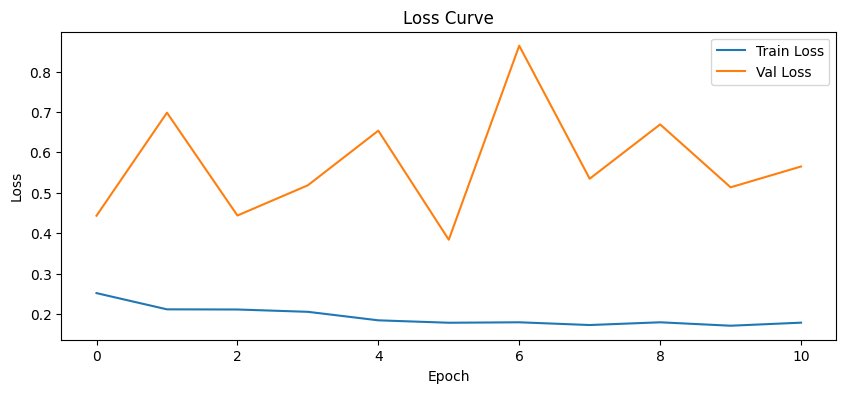

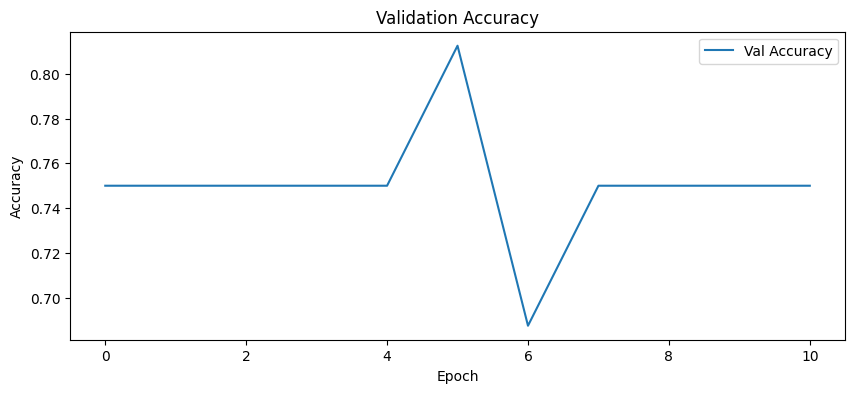

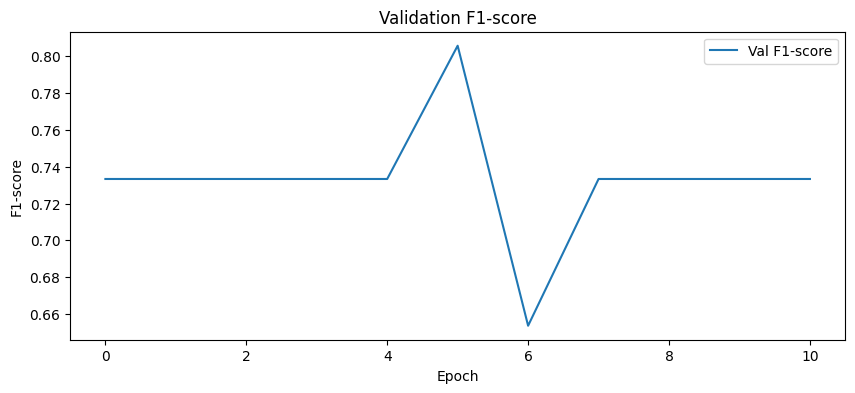

In [46]:
# 1. Loss Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 2. Accuracy Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10,4))
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 3. F1-score Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10,4))
plt.plot(history['val_f1'], label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score')
plt.legend()
plt.show()

### ÌõàÎ†® Í≤∞Í≥º

1. Loss (Train / Val)
    - Train loss Îäî Íæ∏Ï§ÄÌûà Í∞êÏÜå(0.25 ‚Üí 0.17)ÌïòÎ©∞, ÏïàÏ†ïÏ†Å
    - Vall lossÎäî ÏßÑÎèôÏù¥ Ïã¨ÌïòÍ≥†, ÏóêÌè≠ÎßàÎã§ ÌÅ¨Í≤å Î≥ÄÎèô (0.38 ‚Üí 0.86)

    ü§îÏú†Ï∂î Í∞ÄÎä•Ìïú ÏõêÏù∏
      - Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖãÏù¥ ÏûëÎã§ (16Í∞ú), ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï, Îç∞Ïù¥ÌÑ∞ Îã§ÏñëÏÑ± Î∂ÄÏ°±, Ï¶ùÍ∞ï Î∂ÄÏ°±
      - Î™®Îç∏Ïù¥ validation setÏóê Ï†ÅÌï©ÌïòÏßÄ ÏïäÍ≥†, Î∂àÏïàÏ†ï

    ‚û°Ô∏è Ìï¥ÏÑù
    - Î™®Îç∏Ïù¥ train dataÏóêÎäî Ïûò Ï†ÅÏùëÌïòÏßÄÎßå, val dataÏóêÎäî ÏùºÍ¥ÄÏÑ±ÏûàÍ≤å ÏùºÎ∞òÌôîÌïòÏßÄ Î™ªÌïòÍ≥† ÏûàÏùå.
    - Í≥ºÏ†ÅÌï©ÏùÄ Ïã¨ÌïòÏßÄ ÏïäÏúºÎÇò, ÏùºÎ∞òÌôî ÏÑ±Îä•Ïù¥ Î∂àÏïàÏ†ïÌï®.

2. Validation Accuracy & F1-score
   - ÎåÄÎ∂ÄÎ∂Ñ 0.75ÏóêÏÑú Í≥†Ï†ï. (0.81 ÏÉÅÏäπ, 0.69 ÌïòÎùΩ)
   - Î™®Îç∏Ïù¥ validation setÏùò ÏùºÎ∂Ä ÏÉòÌîåÏóê ÎØºÍ∞êÌïòÍ≤å Î∞òÏùë.
   - ÏÑ±Îä• Ï†ïÏ≤¥ ÏÉÅÌÉú.

In [48]:
pretrained_model_finetunebest_load = pretrained_model.to(device)
pretrained_model_finetunebest_load.load_state_dict(torch.load('pth/resnet18_freeze_CrossEntropyLoss_20250626_100835_best_epoch005_val0.383615_acc0.8125_f10.8057.pth', map_location=device))
pretrained_model_finetunebest_load.to(device)
pretrained_model_finetunebest_load.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = pretrained_model_finetunebest_load(X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 3. ÏßÄÌëú Í≥ÑÏÇ∞
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.8606
Test F1-score: 0.8559
Confusion Matrix:
[[163  71]
 [ 16 374]]


### Test Í≤∞Í≥º
- Test Accuray : 0.8606 (86%)
- Test F1-score : 0.8559

- confusion Matrix
    - TN(Ï†ïÏÉÅ-Ï†ïÏÉÅ) : 163
    - FP(Ï†ïÏÉÅ-ÌéòÎ†¥) : 71
    - FN(ÌèêÎ†¥-Ï†ïÏÉÅ) : 16
    - TP(ÌéòÎ†¥-ÌèêÎ†¥) : 374

‚û°Ô∏è Ìï¥ÏÑù
- ÌèêÎ†¥ ÌôòÏûê(ÏñëÏÑ±) Í≤ÄÏ∂úÏùÄ Îß§Ïö∞ ÏûòÌï® (FN=16, TP=274 ‚Üí Ïû¨ÌòÑÏú® ÎÜíÏùå)
- Ï†ïÏÉÅ ÌôòÏûê(ÏùåÏÑ±)ÏóêÏÑú Ïò§Î∂ÑÎ•òÍ∞Ä ÎßéÏùå (FP=71, TN=163 ‚Üí Ï†ïÎ∞ÄÎèÑ ÎÇÆÏùå)
- ÏñëÏÑ± Í≥ºÌÉêÏßÄ / ÏùåÏÑ± ÎàÑÎùΩ
- Ïã§Ï†ú ÏùòÎ£å ÌòÑÏû•ÏóêÏÑúÎäî ÌèêÎ†¥ÏùÑ ÎÜìÏπòÏßÄ ÏïäÎäî Í≤ÉÏù¥ Îçî Ï§ëÏöîÌïòÎØÄÎ°ú, Ïù¥ Í≤∞Í≥ºÎäî Ïã§Ïö©Ï†ÅÏùº Ïàò ÏûàÏùå.

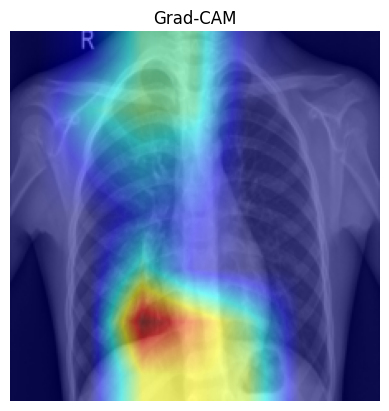

In [50]:
# 1. Î™®Îç∏ Ï§ÄÎπÑ (Ïù¥ÎØ∏ ÌïôÏäµÎêú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞)
pretrained_model_finetunebest_load.eval()

# 2. Grad-CAM Í∞ùÏ≤¥ ÏÉùÏÑ± (ÎßàÏßÄÎßâ conv layer ÏßÄÏ†ï)
target_layer = pretrained_model_finetunebest_load.layer4[-1]  # ResNet18Ïùò ÎßàÏßÄÎßâ conv block
cam = GradCAM(model=pretrained_model_finetunebest_load, target_layers=[target_layer])

# 3. ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ 1Ïû• Î∂àÎü¨Ïò§Í∏∞
img_tensor, label = test_dataset[0]  # (C, H, W), torch.Tensor
input_tensor = img_tensor.unsqueeze(0).to(device)  # Î∞∞Ïπò Ï∞®Ïõê Ï∂îÍ∞Ä

# 4. CAM ÏÉùÏÑ±
grayscale_cam = cam(input_tensor=input_tensor)[0]  # (H, W), numpy

# 5. ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÎ°ú Î≥ÄÌôò
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # 0~1 Ï†ïÍ∑úÌôî

# 6. CAM ÏãúÍ∞ÅÌôî
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

## Case2

todo
- Îç∞Ïù¥ÌÑ∞
    1. Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ‚úÖ
    2. WeightedRandomSampler Îßå ‚úÖ
    3. loss functionÏóê class weight Ï†ÅÏö© Îßå ‚ùå
    4. 2ÏôÄ 3 ÎèôÏãú ‚ùå
- ÌõàÎ†®
    1. Stratified K-Fold Cross Validation ‚ùå

### transform ÎßåÎì§Í∏∞

Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï

In [8]:
crop_h, crop_w = 224, 224 #ResNet18 Í∏∞Î≥∏ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞

# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Ï†ïÏùò
data_transforms_v2 = {
    'train': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Ï°∞Ï†ï
        v2.RandomHorizontalFlip(),
        v2.RandomCrop((200, 200)),          # ÎûúÎç§ ÌÅ¨Î°≠ (200x200)
        v2.RandomRotation(20),              # ÎûúÎç§ ÌöåÏ†Ñ (-20ÎèÑ ~ 20ÎèÑ)
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        v2.ToTensor(),                       # ÌÖêÏÑúÎ°ú Î≥ÄÌôò
        v2.Normalize([0.5], [0.5])          # Ï†ïÍ∑úÌôî
    ]),
    'val': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Ï°∞Ï†ï
        v2.ToTensor(),                       # ÌÖêÏÑúÎ°ú Î≥ÄÌôò
        v2.Normalize([0.5], [0.5])          # Ï†ïÍ∑úÌôî
    ]),
    'test': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Ï°∞Ï†ï
        v2.ToTensor(),                       # ÌÖêÏÑúÎ°ú Î≥ÄÌôò
        v2.Normalize([0.5], [0.5])          # Ï†ïÍ∑úÌôî
    ])
}

/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### dataset ÎßåÎì§Í∏∞

In [9]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
train_dataset_v2 = datasets.ImageFolder(train_dir, transform=data_transforms_v2['train'])
val_dataset_v2 = datasets.ImageFolder(val_dir, transform=data_transforms_v2['val'])
test_dataset_v2 = datasets.ImageFolder(test_dir, transform=data_transforms_v2['test'])

In [10]:
print(f"Train dataset size: {len(train_dataset_v2)}")
print(f"Validation dataset size: {len(val_dataset_v2)}")
print(f"Test dataset size: {len(test_dataset_v2)}")

Train dataset size: 5216
Validation dataset size: 16
Test dataset size: 624


WeightedRandomSamplerÎ°ú ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï ÏôÑÌôîÌïòÍ∏∞

https://medium.com/data-science/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452

In [11]:
class_counts = Counter(train_dataset_v2.targets)
print(class_counts)

Counter({1: 3875, 0: 1341})


In [12]:
num_samples = len(train_dataset_v2)
class_sample_count = np.array([class_counts[i] for i in range(len(class_counts))])
weight = 1. / class_sample_count
samples_weight = np.array([weight[i] for i in train_dataset_v2.targets])

print(f"class_sample_count : {class_sample_count}")
print(f"samples_weight : {samples_weight}")

class_sample_count : [1341 3875]
samples_weight : [0.00074571 0.00074571 0.00074571 ... 0.00025806 0.00025806 0.00025806]


In [13]:
samples_weight = torch.from_numpy(samples_weight).float()
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

### dataloader ÎßåÎì§Í∏∞

In [15]:
# DataLoader ÏÉùÏÑ±
train_loader_v2 = DataLoader(train_dataset_v2, batch_size=32, sampler=sampler, num_workers=2, shuffle=False)
val_loader_v2 = DataLoader(val_dataset_v2, batch_size=32, num_workers=2, shuffle=False)
test_loader_v2 = DataLoader(test_dataset_v2, batch_size=32, num_workers=2, shuffle=False)


### Î™®Îç∏

In [16]:
pretrained_model_v2 = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

In [17]:
summary(pretrained_model_v2, (1, 3, 224, 224), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
‚îú‚îÄConv2d: 1-1                            [1, 64, 112, 112]         9,408
‚îú‚îÄBatchNorm2d: 1-2                       [1, 64, 112, 112]         128
‚îú‚îÄReLU: 1-3                              [1, 64, 112, 112]         --
‚îú‚îÄMaxPool2d: 1-4                         [1, 64, 56, 56]           --
‚îú‚îÄSequential: 1-5                        [1, 64, 56, 56]           --
‚îÇ    ‚îî‚îÄBasicBlock: 2-1                   [1, 64, 56, 56]           --
‚îÇ    ‚îÇ    ‚îî‚îÄConv2d: 3-1                  [1, 64, 56, 56]           36,864
‚îÇ    ‚îÇ    ‚îî‚îÄBatchNorm2d: 3-2             [1, 64, 56, 56]           128
‚îÇ    ‚îÇ    ‚îî‚îÄReLU: 3-3                    [1, 64, 56, 56]           --
‚îÇ    ‚îÇ    ‚îî‚îÄConv2d: 3-4                  [1, 64, 56, 56]           36,864
‚îÇ    ‚îÇ    ‚îî‚îÄBatchNorm2d: 3-5             [1, 64, 56, 56]           128
‚îÇ  

### features freeze, classifier ÍµêÏ≤¥

### 1. Î∂ÑÎ•òÍ∏∞ ÍµêÏ≤¥ (2ÌÅ¥ÎûòÏä§)

In [18]:
num_ftrs = pretrained_model_v2.fc.in_features  # ImageNetÏö© ResNet18ÏùÄ nn.Linear(512, 1000) Íµ¨Ï°∞ -> num_ftrs = 512
pretrained_model_v2.fc = nn.Linear(num_ftrs, 2)  # ÌÅ¥ÎûòÏä§ Ïàò = 2 (NORMAL, PNEUMONIA) # ÎßàÏßÄÎßâ FC layerÎ•º 512->2Î°ú Î≥ÄÍ≤Ω
pretrained_model_v2 = pretrained_model_v2.to(device)

### 2. features freeze (Í∞ÄÏ§ëÏπò Í≥†Ï†ï)

In [19]:
for param in pretrained_model_v2.parameters():
    param.requires_grad = False  # Î™®Îì† ÌååÎùºÎØ∏ÌÑ∞ freeze

for param in pretrained_model_v2.layer4.parameters(): # ÎßàÏßÄÎßâ conv layerÎßå unfreeze
    param.requires_grad = True
for param in pretrained_model_v2.fc.parameters():
    param.requires_grad = True   # Î∂ÑÎ•òÍ∏∞Îßå ÌïôÏäµ

### 3. ÏÜêÏã§Ìï®Ïàò, ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï†ïÏùò

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model_v2.fc.parameters(), lr=1e-3)

### 4. train

In [24]:
history = train_model(
    pretrained_model_v2,           
    criterion,                  # ÏÜêÏã§ Ìï®Ïàò
    optimizer,                  # ÏòµÌã∞ÎßàÏù¥Ï†Ä
    train_loader_v2,               
    val_loader_v2,                 
    device,                     
    num_epochs=100,              
    model_name="resnet18_freeze", 
    patience=12,                  
    delta=0.0005,
)

[resnet18_freeze] Epoch 0 step 50 train_loss = 0.185696
[resnet18_freeze] Epoch 0 step 100 train_loss = 0.213204
[resnet18_freeze] Epoch 0 step 150 train_loss = 0.318011
[resnet18_freeze] Epoch 0 train_loss = 0.235944 val_loss=0.328654 val_accuracy=0.812500 val_f1=0.805668
‚Ü≥ New best model saved: ./pth/resnet18_freeze_CrossEntropyLoss_20250626_122015_best_epoch000_val0.328654_acc0.8125_f10.8057.pth
[resnet18_freeze] Epoch 1 step 50 train_loss = 0.209639
[resnet18_freeze] Epoch 1 step 100 train_loss = 0.190307
[resnet18_freeze] Epoch 1 step 150 train_loss = 0.209228
[resnet18_freeze] Epoch 1 train_loss = 0.233985 val_loss=0.278420 val_accuracy=0.875000 val_f1=0.873016
‚Ü≥ New best model saved: ./pth/resnet18_freeze_CrossEntropyLoss_20250626_122104_best_epoch001_val0.278420_acc0.8750_f10.8730.pth
[resnet18_freeze] Epoch 2 step 50 train_loss = 0.170810
[resnet18_freeze] Epoch 2 step 100 train_loss = 0.116559
[resnet18_freeze] Epoch 2 step 150 train_loss = 0.325224
[resnet18_freeze] Epoc

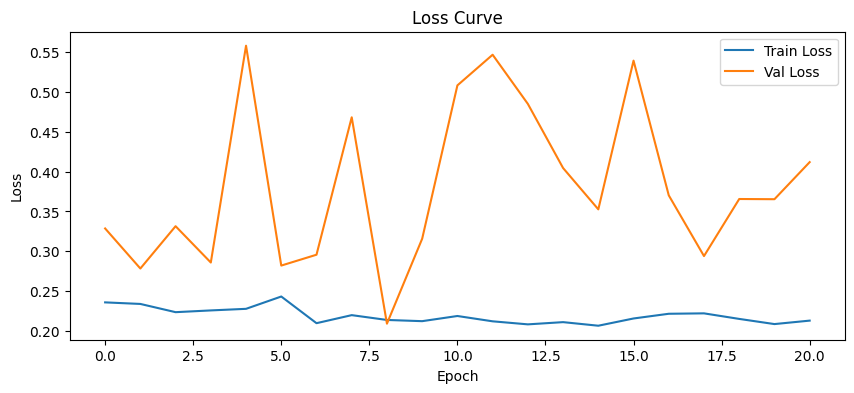

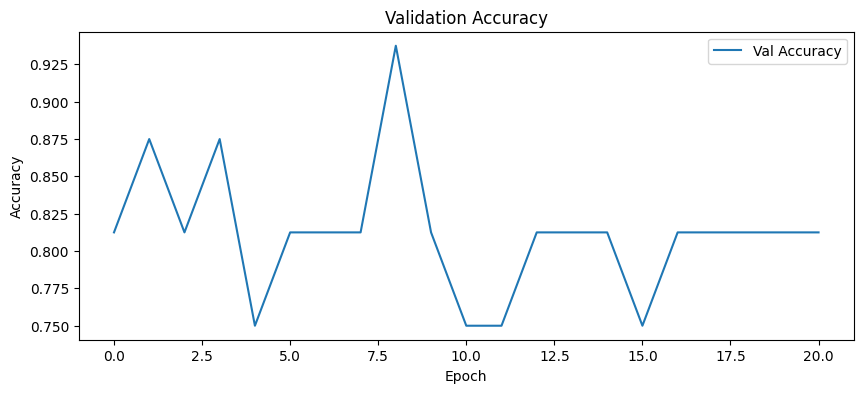

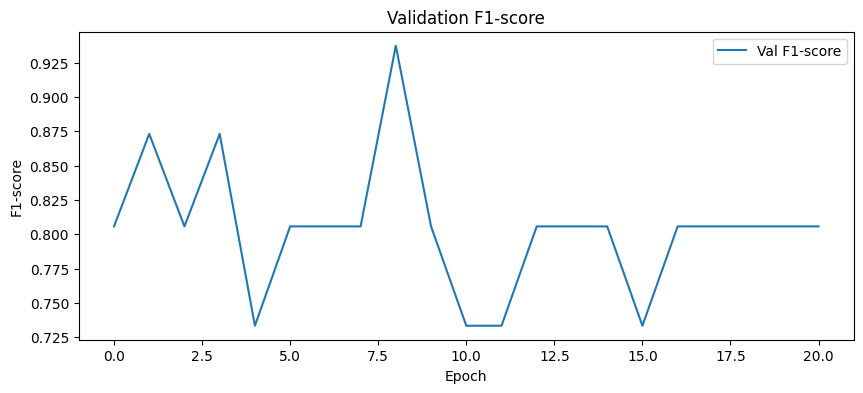

In [25]:
# 1. Loss Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 2. Accuracy Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10,4))
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 3. F1-score Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10,4))
plt.plot(history['val_f1'], label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score')
plt.legend()
plt.show()

In [26]:
pretrained_model_v2_finetunebest_load = pretrained_model_v2.to(device)
pretrained_model_v2_finetunebest_load.load_state_dict(torch.load('pth/resnet18_freeze_CrossEntropyLoss_20250626_122652_best_epoch008_val0.209221_acc0.9375_f10.9373.pth', map_location=device))
pretrained_model_v2_finetunebest_load.to(device)
pretrained_model_v2_finetunebest_load.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader_v2:
        X, y = X.to(device), y.to(device)
        outputs = pretrained_model_v2_finetunebest_load(X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 3. ÏßÄÌëú Í≥ÑÏÇ∞
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.8766
Test F1-score: 0.8762
Confusion Matrix:
[[192  42]
 [ 35 355]]


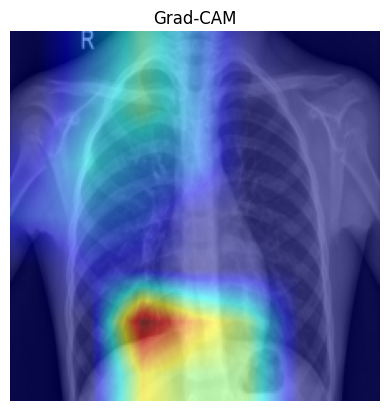

In [29]:
# 1. Î™®Îç∏ Ï§ÄÎπÑ (Ïù¥ÎØ∏ ÌïôÏäµÎêú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞)
pretrained_model_v2_finetunebest_load.eval()

# 2. Grad-CAM Í∞ùÏ≤¥ ÏÉùÏÑ± (ÎßàÏßÄÎßâ conv layer ÏßÄÏ†ï)
target_layer = pretrained_model_v2_finetunebest_load.layer4[-1]  # ResNet18Ïùò ÎßàÏßÄÎßâ conv block
cam = GradCAM(model=pretrained_model_v2_finetunebest_load, target_layers=[target_layer])

# 3. ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ 1Ïû• Î∂àÎü¨Ïò§Í∏∞
img_tensor, label = test_dataset_v2[0]  # (C, H, W), torch.Tensor
input_tensor = img_tensor.unsqueeze(0).to(device)  # Î∞∞Ïπò Ï∞®Ïõê Ï∂îÍ∞Ä

# 4. CAM ÏÉùÏÑ±
grayscale_cam = cam(input_tensor=input_tensor)[0]  # (H, W), numpy

# 5. ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÎ°ú Î≥ÄÌôò
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # 0~1 Ï†ïÍ∑úÌôî

# 6. CAM ÏãúÍ∞ÅÌôî
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

1. Ïã§Ìóò ÌôòÍ≤Ω ÏöîÏïΩ

Îç∞Ïù¥ÌÑ∞ÏÖã
- Train: 5,216 (Ï†ïÏÉÅ 1,341, ÌèêÎ†¥ 3,875, Î∂àÍ∑†Ìòï Ïã¨Ìï®)
- Val: 16 (Îß§Ïö∞ Ï†ÅÏùå)
- Test: 624

Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï: trainÏóêÎßå Îã§ÏñëÌïú augmentation Ï†ÅÏö©

ÏÉòÌîåÎßÅ:
- WeightedRandomSamplerÎ°ú ÌïôÏäµ Î∞∞ÏπòÏùò ÌÅ¥ÎûòÏä§ Í∑†Ìòï ÎßûÏ∂§
- class_weight ÎØ∏Ï†ÅÏö© (ÏÜêÏã§Ìï®ÏàòÎäî Í∏∞Î≥∏ CrossEntropyLoss)

Î™®Îç∏: ResNet18, feature freeze, ÎßàÏßÄÎßâ conv layerÏôÄ fcÎßå ÌïôÏäµ

Optimizer: Adam (fc ÌååÎùºÎØ∏ÌÑ∞Îßå)

Early Stopping: patience=12, delta=0.0005

ÏóêÌè≠: 20ÏóêÏÑú Ï°∞Í∏∞ Ï¢ÖÎ£å

2. ÌïôÏäµ/Í≤ÄÏ¶ù Î°úÍ∑∏ Î∞è Í∑∏ÎûòÌîÑ Î∂ÑÏÑù

(1) Loss Courve
- Train Loss : 0.21~0.24Î°ú Îß§Ïö∞ ÏïàÏ†ïÏ†Å, Í≥ºÏ†ÅÌï© ÏóÜÏùå
- Val Loss : 0.21~0.55Î°ú ÏßÑÎèô, ÏóêÌè≠Î≥Ñ Îì±ÎùΩÏù¥ ÌÅº
    - ÏõêÏù∏:
        - Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏÖãÏù¥ 16Í∞úÎ°ú Îß§Ïö∞ ÏûëÏùå. -> ÌïúÎëê ÏÉòÌîåÏóê Îî∞Îùº lossÍ∞Ä ÌÅ¨Í≤å Î≥ÄÎèô
        - Îç∞Ïù¥ÌÑ∞ Îã§ÏñëÏÑ± Î∂ÄÏ°± -> fold ÏÇ¨Ïö© Í≤ÄÌÜ† Í≥†Î†§

(2) Validation Accuracy & F1-score
- Accuracy/F1-score 0.75~0.94, ÎåÄÎ∂ÄÎ∂Ñ 0.81~0.87
- ÏÑ±Îä• Ï†ïÏ≤¥.
- Accuracy/F1-scoreÍ∞Ä Í±∞Ïùò ÎèôÏùº -> ÌÅ¥ÎûòÏä§ Î∂àÍ∑†ÌòïÏù¥ Ïã¨ÌïòÏßÄÎßå, ÏÉòÌîåÎü¨Î°ú Ïñ¥ÎäêÏ†ïÎèÑ Î≥¥Ï†ï

(3) Test Í≤∞Í≥º
- Test Accuracy: 0.8766
- Test F1-score: 0.8762
- Confusion Matrix:
    - TN(Ï†ïÏÉÅ-Ï†ïÏÉÅ) : 192
    - FP(Ï†ïÏÉÅ-ÌéòÎ†¥) : 42
    - FN(ÌèêÎ†¥-Ï†ïÏÉÅ) : 35
    - TP(ÌéòÎ†¥-ÌèêÎ†¥) : 355

‚û°Ô∏è ÌèêÎ†¥ÏùÑ Ï†ïÏÉÅÏúºÎ°ú Î∂ÑÎ•òÍ∞Ä 35Í±¥Ïù¥Îã§.

3. Í∞úÏÑ† Ï†úÏïà

(1) Stratified K-Fold Cross Validation

(2) class_weight Ï†ÅÏö© (FNÏùÑ Îçî Ï§ÑÏùº Ïàò ÏûàÏùÑÏßÄ)

(3) Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Îã§ÏñëÌôî

## Case 3

todo
- Îç∞Ïù¥ÌÑ∞
    1. Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ‚úÖ
- ÌõàÎ†®
    1. Stratified K-Fold Cross Validation ‚úÖ

### transform ÎßåÎì§Í∏∞

Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï

In [8]:
crop_h, crop_w = 224, 224 #ResNet18 Í∏∞Î≥∏ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞

# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Ï†ïÏùò
data_transforms_v3 = {
    'train': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Ï°∞Ï†ï
        v2.RandomHorizontalFlip(),
        v2.RandomCrop((200, 200)),          # ÎûúÎç§ ÌÅ¨Î°≠ (200x200)
        v2.RandomRotation(20),              # ÎûúÎç§ ÌöåÏ†Ñ (-20ÎèÑ ~ 20ÎèÑ)
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        v2.ToTensor(),                       # ÌÖêÏÑúÎ°ú Î≥ÄÌôò
        v2.Normalize([0.5], [0.5])          # Ï†ïÍ∑úÌôî
    ]),
    'val': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Ï°∞Ï†ï
        v2.ToTensor(),                       # ÌÖêÏÑúÎ°ú Î≥ÄÌôò
        v2.Normalize([0.5], [0.5])          # Ï†ïÍ∑úÌôî
    ]),
    'test': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Ï°∞Ï†ï
        v2.ToTensor(),                       # ÌÖêÏÑúÎ°ú Î≥ÄÌôò
        v2.Normalize([0.5], [0.5])          # Ï†ïÍ∑úÌôî
    ])
}

/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### dataset ÎßåÎì§Í∏∞

In [9]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
train_dataset_v3 = datasets.ImageFolder(train_dir, transform=data_transforms_v3['train'])
val_dataset_v3 = datasets.ImageFolder(val_dir, transform=data_transforms_v3['val'])
test_dataset_v3 = datasets.ImageFolder(test_dir, transform=data_transforms_v3['test'])

In [10]:
print(f"Train dataset size: {len(train_dataset_v3)}")
print(f"Validation dataset size: {len(val_dataset_v3)}")
print(f"Test dataset size: {len(test_dataset_v3)}")

Train dataset size: 5216
Validation dataset size: 16
Test dataset size: 624


In [23]:
test_loader_v3 = DataLoader(test_dataset_v3, batch_size=32, num_workers=2, shuffle=False)

Stratified K-Fold

In [11]:
labels = train_dataset_v3.targets
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [13]:
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"Fold {fold+1} / {n_splits} :: train_idx: {len(train_idx)}, val_idx: {len(val_idx)}")
    print(f"Fold {fold+1} / {n_splits} :: train_idx: {train_idx[:5]}, val_idx: {val_idx[:5]}")
    print(f"Fold {fold+1} / {n_splits} :: train_idx: {train_idx[-5:]}, val_idx: {val_idx[-5:]}")
    print(f"Fold {fold+1} / {n_splits} :: train_idx: {train_idx}, val_idx: {val_idx}")
    print(f"Fold {fold+1} / {n_splits} :: train_idx: {train_idx}, val_idx: {val_idx}")

    break

Fold 1 / 5 :: train_idx: 4172, val_idx: 1044
Fold 1 / 5 :: train_idx: [0 1 2 3 5], val_idx: [ 4 12 13 23 39]
Fold 1 / 5 :: train_idx: [5208 5209 5210 5213 5214], val_idx: [5195 5203 5211 5212 5215]
Fold 1 / 5 :: train_idx: [   0    1    2 ... 5210 5213 5214], val_idx: [   4   12   13 ... 5211 5212 5215]
Fold 1 / 5 :: train_idx: [   0    1    2 ... 5210 5213 5214], val_idx: [   4   12   13 ... 5211 5212 5215]


In [16]:
class make_data_loader:
    def __init__(self, train_idx, val_idx, train_dataset, val_dataset, batch_size=32, num_workers=2):
        self.train_idx = train_idx
        self.val_idx = val_idx
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers

    def get_train_loader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
    
    def get_val_loader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
    

In [17]:
class make_resnet18_classifier:
    def __init__(self, num_classes=2, freeze_features=True, device='cpu', weights='ResNet18_Weights.IMAGENET1K_V1'):
        self.weights = weights
        self.num_classes = num_classes
        self.device = device

        self.pretrained_model = models.resnet18(weights=self.weights)
        num_ftrs = self.pretrained_model.fc.in_features
        self.pretrained_model.fc = nn.Linear(num_ftrs, self.num_classes)
        self.pretrained_model = self.pretrained_model.to(self.device)

        # feature freeze
        if freeze_features:
            for param in self.pretrained_model.parameters():
                param.requires_grad = False
            for param in self.pretrained_model.layer4.parameters():
                param.requires_grad = True
            for param in self.pretrained_model.fc.parameters():
                param.requires_grad = True

    def get_model(self):
        return self.pretrained_model
    
    def get_num_classes(self):
        return self.num_classes

In [18]:
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"Fold {fold+1} / {n_splits}")
    
    # SubsetÏúºÎ°ú foldÎ≥Ñ Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
    train_subset = Subset(train_dataset_v3, train_idx)
    val_subset = Subset(train_dataset_v3, val_idx)

    # ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ ÌôïÏù∏ (ÏÑ†ÌÉù)
    train_targets = [labels[i] for i in train_idx]
    val_targets = [labels[i] for i in val_idx]
    print("Train Î∂ÑÌè¨:", Counter(train_targets))
    print("Val Î∂ÑÌè¨:", Counter(val_targets))

    # DataLoader ÏÉùÏÑ± (ÏÉòÌîåÎü¨ ÏóÜÏù¥ shuffleÎßå ÏÇ¨Ïö©)
    data_loader_builder = make_data_loader(train_idx, val_idx, train_subset, val_subset, batch_size=32, num_workers=2)
    train_loader_v3 = data_loader_builder.get_train_loader()
    val_loader_v3 = data_loader_builder.get_val_loader()

    # Î™®Îç∏, optimizer, criterion Îì± foldÎßàÎã§ ÏÉàÎ°ú ÏÉùÏÑ±

    model_builder = make_resnet18_classifier(num_classes=2, freeze_features=True, device=device)
    model_v3 = model_builder.get_model()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_v3.fc.parameters(), lr=1e-3)

    # ÌïôÏäµ
    history = train_model(
        model_v3,                    
        criterion,                  # ÏÜêÏã§ Ìï®Ïàò
        optimizer,                  # ÏòµÌã∞ÎßàÏù¥Ï†Ä
        train_loader_v3,               
        val_loader_v3,                 
        device,                     
        num_epochs=100,             
        model_name=f"resnet18_fold{fold+1}",
        patience=12,                  # Ï°∞Í∏∞ Ï¢ÖÎ£å ÌååÎùºÎØ∏ÌÑ∞
        delta=0.0005,
    )


Fold 1 / 5
Train Î∂ÑÌè¨: Counter({1: 3100, 0: 1072})
Val Î∂ÑÌè¨: Counter({1: 775, 0: 269})
[resnet18_fold1] Epoch 0 step 50 train_loss = 0.492656
[resnet18_fold1] Epoch 0 step 100 train_loss = 0.417353
[resnet18_fold1] Epoch 0 train_loss = 0.377782 val_loss=0.290073 val_accuracy=0.863985 val_f1=0.854898
‚Ü≥ New best model saved: ./pth/resnet18_fold1_CrossEntropyLoss_20250626_151531_best_epoch000_val0.290073_acc0.8640_f10.8549.pth
[resnet18_fold1] Epoch 1 step 50 train_loss = 0.302961
[resnet18_fold1] Epoch 1 step 100 train_loss = 0.194919
[resnet18_fold1] Epoch 1 train_loss = 0.267877 val_loss=0.257487 val_accuracy=0.879310 val_f1=0.869458
‚Ü≥ New best model saved: ./pth/resnet18_fold1_CrossEntropyLoss_20250626_151624_best_epoch001_val0.257487_acc0.8793_f10.8695.pth
[resnet18_fold1] Epoch 2 step 50 train_loss = 0.118874
[resnet18_fold1] Epoch 2 step 100 train_loss = 0.265452
[resnet18_fold1] Epoch 2 train_loss = 0.239651 val_loss=0.265554 val_accuracy=0.898467 val_f1=0.901678
[resnet18

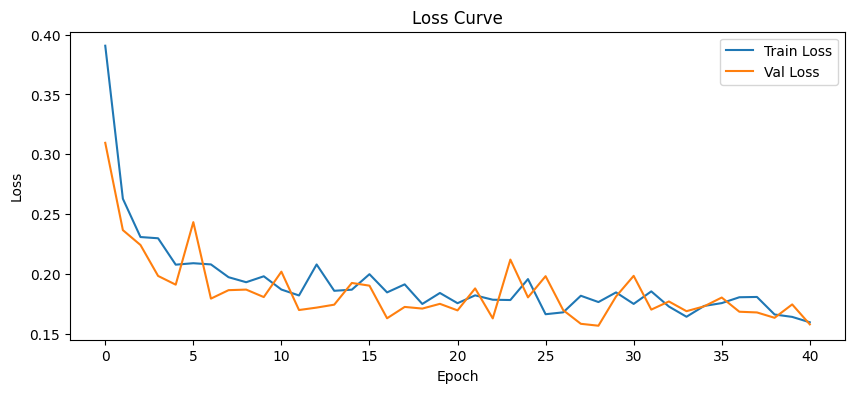

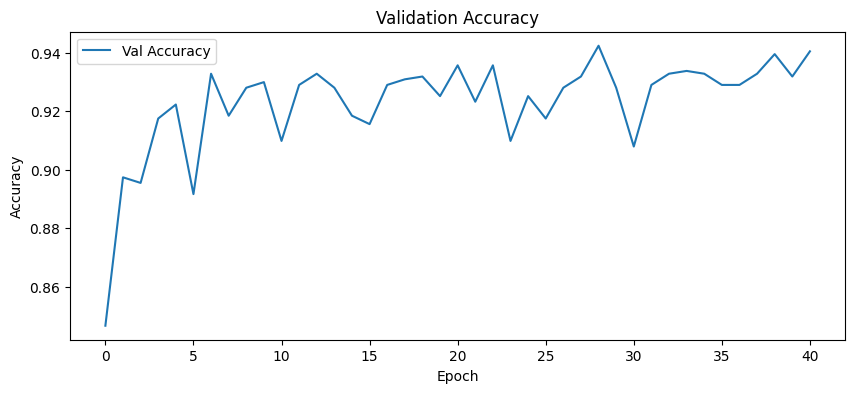

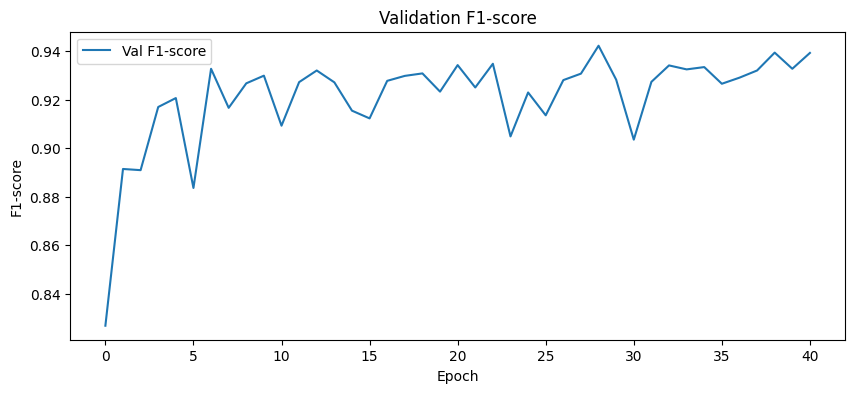

In [27]:
# 1. Loss Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 2. Accuracy Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10,4))
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 3. F1-score Í∑∏ÎûòÌîÑ
plt.figure(figsize=(10,4))
plt.plot(history['val_f1'], label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score')
plt.legend()
plt.show()

In [20]:
pretrained_model_v3_finetunebest_load = model_v3.to(device)
pretrained_model_v3_finetunebest_load.load_state_dict(torch.load('pth/resnet18_fold2_CrossEntropyLoss_20250626_160634_best_epoch016_val0.126289_acc0.9569_f10.9568.pth', map_location=device))
pretrained_model_v3_finetunebest_load.to(device)
pretrained_model_v3_finetunebest_load.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader_v3:
        X, y = X.to(device), y.to(device)
        outputs = pretrained_model_v3_finetunebest_load(X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 3. ÏßÄÌëú Í≥ÑÏÇ∞
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.8462
Test F1-score: 0.8384
Confusion Matrix:
[[149  85]
 [ 11 379]]


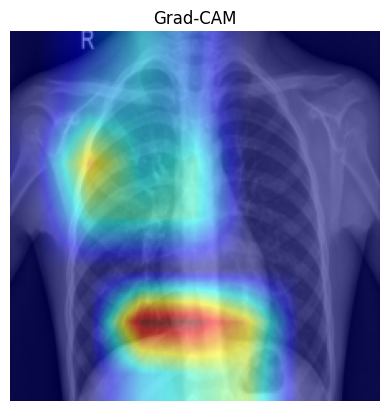

In [26]:
# 1. Î™®Îç∏ Ï§ÄÎπÑ (Ïù¥ÎØ∏ ÌïôÏäµÎêú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞)
pretrained_model_v3_finetunebest_load.eval()

# 2. Grad-CAM Í∞ùÏ≤¥ ÏÉùÏÑ± (ÎßàÏßÄÎßâ conv layer ÏßÄÏ†ï)
target_layer = pretrained_model_v3_finetunebest_load.layer4[-1]  # ResNet18Ïùò ÎßàÏßÄÎßâ conv block
cam = GradCAM(model=pretrained_model_v3_finetunebest_load, target_layers=[target_layer])

# 3. ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ 1Ïû• Î∂àÎü¨Ïò§Í∏∞
img_tensor, label = test_dataset_v3[0]  # (C, H, W), torch.Tensor
input_tensor = img_tensor.unsqueeze(0).to(device)  # Î∞∞Ïπò Ï∞®Ïõê Ï∂îÍ∞Ä

# 4. CAM ÏÉùÏÑ±
grayscale_cam = cam(input_tensor=input_tensor)[0]  # (H, W), numpy

# 5. ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÎ°ú Î≥ÄÌôò
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # 0~1 Ï†ïÍ∑úÌôî

# 6. CAM ÏãúÍ∞ÅÌôî
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

### FP / FN ÏºÄÏù¥Ïä§ ÏãúÍ∞ÅÌôî

Ïò§ÌÉê(False Positive, FP): Ïã§Ï†úÎäî Ï†ïÏÉÅ(0)Ïù∏Îç∞ ÌèêÎ†¥(1)ÏúºÎ°ú ÏòàÏ∏°Ìïú Í≤ΩÏö∞

ÎØ∏ÌÉê(False Negative, FN): Ïã§Ï†úÎäî ÌèêÎ†¥(1)Ïù∏Îç∞ Ï†ïÏÉÅ(0)ÏúºÎ°ú ÏòàÏ∏°Ìïú Í≤ΩÏö∞

In [30]:
pretrained_model_v3_finetunebest_load.eval()
all_images, all_labels, all_preds = [], [], []

with torch.no_grad():
    for images, labels in test_loader_v3:
        images = images.to(device)
        outputs = pretrained_model_v3_finetunebest_load(images)
        _, preds = torch.max(outputs, 1)
        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())

all_images = torch.cat(all_images)
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

# Ïò§ÌÉê/ÎØ∏ÌÉê Ïù∏Îç±Ïä§
fp_idx = (all_labels == 0) & (all_preds == 1)  # False Positive
fn_idx = (all_labels == 1) & (all_preds == 0)  # False Negative

fp_images = all_images[fp_idx]
fn_images = all_images[fn_idx]

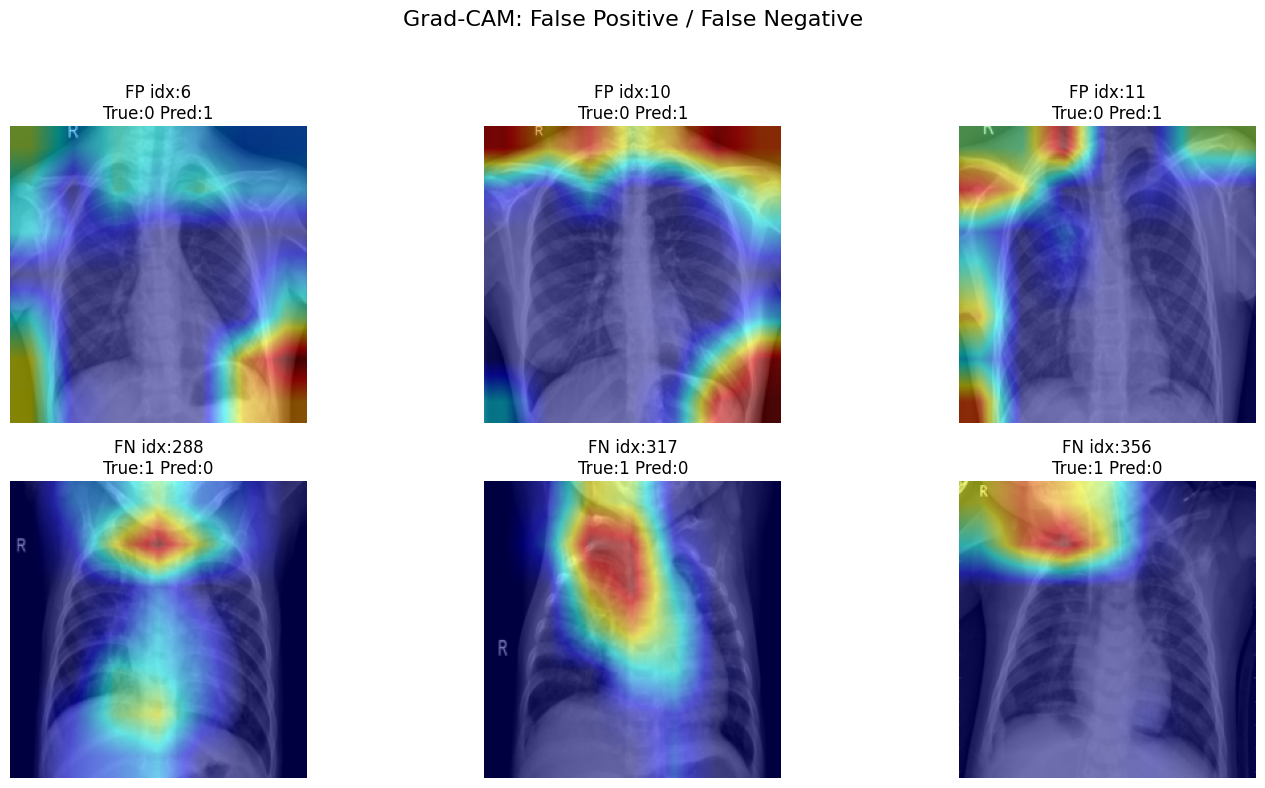

In [35]:
fp_indices = torch.where(fp_idx)[0][:3]
fn_indices = torch.where(fn_idx)[0][:3]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Grad-CAM: False Positive / False Negative", fontsize=16)

# Ïò§ÌÉê(FP) subplot
for i, idx in enumerate(fp_indices):
    input_tensor = all_images[idx].unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=input_tensor)[0]
    img = all_images[idx].numpy().transpose(1,2,0)
    img = (img - img.min()) / (img.max() - img.min())
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    axes[0, i].imshow(visualization)
    axes[0, i].set_title(f"FP idx:{idx.item()}\nTrue:0 Pred:1")
    axes[0, i].axis('off')

# ÎØ∏ÌÉê(FN) subplot
for i, idx in enumerate(fn_indices):
    input_tensor = all_images[idx].unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=input_tensor)[0]
    img = all_images[idx].numpy().transpose(1,2,0)
    img = (img - img.min()) / (img.max() - img.min())
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    axes[1, i].imshow(visualization)
    axes[1, i].set_title(f"FN idx:{idx.item()}\nTrue:1 Pred:0")
    axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()